In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm 
import random
%matplotlib inline

In [2]:
#Define word dataset and put it into dictionary
word_set = open('names.txt', 'r').read().splitlines()
print(word_set[:10]) #print 10 words
print(len(word_set))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
32033


In [3]:
#Build vocabulary dictionary (Integer/Character Mappings)
chars = sorted(list(set(''.join(word_set))))
S_to_I = {s: i+1 for i,s in enumerate(chars)} #give each char mapping of i + 1
S_to_I['.'] = 0 #map end of sequence token
I_to_S = {i: s for s,i in S_to_I.items()} #reverse S to I
vocab_size = len(I_to_S)
print(vocab_size)

27


In [4]:
#Build dataset with Context : How many characters needed to predict the next character?
block_size = 3

def build_dataset(words):
    X, Y = [],[]
    for name in tqdm(words, desc = "Building dataset"):
        context = [0] * block_size 
        #Loop through chars, add . to symbolize end token
        for ch in name + '.':
            index = S_to_I[ch]
            X.append(context) #input context
            Y.append(index) #output integer integer to next character
            context = context[1:] + [index] #append context
    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    print(f"Shapes X: {X.shape}, Y: {Y.shape}")
    return X,Y


#Split up data and build datasets for Training, Validation, and Testing
random.seed(29)
random.shuffle(word_set)
idx1 = int(0.8 * len(word_set))
idx2 = int(0.9 * len(word_set))

train_x, train_y = build_dataset(word_set[:idx1]) #First 80 percent for Training
dev_x, dev_y = build_dataset(word_set[idx1:idx2]) #
test_x, test_y = build_dataset(word_set[idx2:]) #10 percent to test



Building dataset: 100%|███████████████| 25626/25626 [00:00<00:00, 180961.92it/s]


Shapes X: torch.Size([182586, 3]), Y: torch.Size([182586])


Building dataset: 100%|█████████████████| 3203/3203 [00:00<00:00, 525847.65it/s]


Shapes X: torch.Size([22738, 3]), Y: torch.Size([22738])


Building dataset: 100%|█████████████████| 3204/3204 [00:00<00:00, 479845.39it/s]

Shapes X: torch.Size([22822, 3]), Y: torch.Size([22822])


In [5]:
#MLP: Embedding Layer, Hidden Layer
n_embd = 10 #embedding table vectors
n_hidden = 200 #hidden layer nuerons
g = torch.Generator().manual_seed(28482948204) 


#Parameters 
#Embedding Lookup Table C
C = torch.randn((vocab_size, n_embd), generator=g) #each row is characters 10 dim vector
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5) #concatenated embeddings into hidden
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 #hidden layer to output logits for each character
b2 = torch.zeros(vocab_size)

#Paramters for Batch Norm to normalize inputs
bnorm_gain = torch.ones((1, n_hidden)) #learnable scale factor gamma
bnorm_bias = torch.zeros((1, n_hidden)) #learned shift factor beta
running_mean = torch.zeros((1, n_hidden)) #running mean
running_std = torch.zeros((1, n_hidden)) #running standard deviation

network_params = [C, W1, W2, b2, bnorm_gain, bnorm_bias]
print(f"Number of Parameters in model {sum(p.nelement() for p in network_params)}")
#ensure that gradients are calculated for back prop
for param in network_params:
    param.requires_grad = True



Number of Parameters in model 12097


In [6]:
lre = torch.linspace(-3,0,1000) #Learning Rate Exponent using 1000 points spaced between -3 and 0
lrs = 10**lre #learning rates betwen 0.001 and 1 for Learning Rate Scheduling
print(lrs[:20]) 

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011])


In [7]:
#Training the Model 
max_epochs = 100_000
batch_size = 32
iteration_loss  = [] #store training losses
validation_loss  = [] #store validation losses

#Adam Optimizer
optim = torch.optim.Adam(network_params, lr=0.001)
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

Training Loop

In [8]:
# Initialize running mean and std
running_mean = torch.zeros((1, n_hidden))
running_std = torch.ones((1, n_hidden))

# Training loop with validation loss tracking
for i in tqdm(range(max_epochs), desc="Training Model"):
    index = torch.randint(0, train_x.shape[0], (batch_size,), generator=g)  # Generate random indices to sample batch size samples
    batch_x, batch_y = train_x[index], train_y[index]

    # Forward
    embedding = C[batch_x]  # Character into embedding vector
    embedding_concat = embedding.view(embedding.shape[0], -1)  # Concatenate embeddings into single vector, -1 infers shape
    hidden_pre_activation = embedding_concat @ W1  # Mat Mul Embedding, Weight Matrix 1

    # Normalize hidden state using running statistics and batch norm
    hidden_pre_activation = bnorm_gain * (hidden_pre_activation - running_mean) / (running_std + 1e-5) + bnorm_bias

    # Update running statistics without gradients
    with torch.no_grad():
        running_mean = 0.999 * running_mean + 0.001 * hidden_pre_activation.mean(0, keepdim=True)
        running_std = 0.999 * running_std + 0.001 * hidden_pre_activation.std(0, keepdim=True)

    hidden = torch.tanh(hidden_pre_activation)
    logits = hidden @ W2 + b2  # Hidden layer into logits, one bias for each char
    loss = F.cross_entropy(logits, batch_y)  # Determine loss based on expected

    # Backward
    optim.zero_grad()  # Reset gradients to avoid accumulation
    loss.backward()  # Backpropagation
    optim.step()  # Update parameters based on gradient

    # Every 5000 iterations, check validation loss
    if i % 5000 == 0:
        print(f'Step {i}/{max_epochs}: Training loss = {loss.item():.4f}')
        with torch.no_grad():
            val_emb = C[dev_x]
            val_embcat = val_emb.view(val_emb.shape[0], -1)
            val_hpreact = val_embcat @ W1
            val_hpreact = bnorm_gain * (val_hpreact - running_mean) / (running_std + 1e-5) + bnorm_bias
            val_h = torch.tanh(val_hpreact)
            val_logits = val_h @ W2 + b2
            val_loss_val = F.cross_entropy(val_logits, dev_y).item()
            validation_loss.append(val_loss_val)
            print(f'Step {i}/{max_epochs}: Validation loss = {val_loss_val:.4f}')
    iteration_loss.append(loss.log10().item())  # Add log likelihood to training loss


Training Model:   0%|                     | 132/100000 [00:00<02:15, 739.52it/s]

Step 0/100000: Training loss = 3.3228
Step 0/100000: Validation loss = 3.2856


Training Model:   5%|▉                  | 5188/100000 [00:04<01:20, 1174.70it/s]

Step 5000/100000: Training loss = 2.3472
Step 5000/100000: Validation loss = 2.2780


Training Model:  10%|█▊                | 10169/100000 [00:08<01:15, 1189.20it/s]

Step 10000/100000: Training loss = 2.1619
Step 10000/100000: Validation loss = 2.2312


Training Model:  15%|██▋               | 15097/100000 [00:12<01:14, 1140.35it/s]

Step 15000/100000: Training loss = 2.0670
Step 15000/100000: Validation loss = 2.2078


Training Model:  20%|███▋              | 20223/100000 [00:16<01:03, 1252.00it/s]

Step 20000/100000: Training loss = 2.1698
Step 20000/100000: Validation loss = 2.1975


Training Model:  25%|████▌             | 25197/100000 [00:20<01:01, 1220.43it/s]

Step 25000/100000: Training loss = 2.1161
Step 25000/100000: Validation loss = 2.1910


Training Model:  30%|█████▍            | 30130/100000 [00:25<00:57, 1215.72it/s]

Step 30000/100000: Training loss = 2.3927
Step 30000/100000: Validation loss = 2.1902


Training Model:  35%|██████▎           | 35246/100000 [00:29<00:52, 1235.82it/s]

Step 35000/100000: Training loss = 2.1031
Step 35000/100000: Validation loss = 2.1853


Training Model:  40%|███████▏          | 40125/100000 [00:33<00:49, 1221.84it/s]

Step 40000/100000: Training loss = 2.2614
Step 40000/100000: Validation loss = 2.1850


Training Model:  45%|████████▏         | 45224/100000 [00:37<00:45, 1193.70it/s]

Step 45000/100000: Training loss = 2.2712
Step 45000/100000: Validation loss = 2.1851


Training Model:  50%|█████████         | 50205/100000 [00:41<00:40, 1244.19it/s]

Step 50000/100000: Training loss = 2.1688
Step 50000/100000: Validation loss = 2.1791


Training Model:  55%|█████████▉        | 55215/100000 [00:45<00:37, 1209.89it/s]

Step 55000/100000: Training loss = 2.4110
Step 55000/100000: Validation loss = 2.1744


Training Model:  60%|██████████▊       | 60142/100000 [00:49<00:33, 1186.94it/s]

Step 60000/100000: Training loss = 2.1376
Step 60000/100000: Validation loss = 2.1642


Training Model:  65%|███████████▋      | 65220/100000 [00:53<00:28, 1229.18it/s]

Step 65000/100000: Training loss = 2.1469
Step 65000/100000: Validation loss = 2.1729


Training Model:  70%|████████████▌     | 70138/100000 [00:57<00:24, 1224.83it/s]

Step 70000/100000: Training loss = 2.0472
Step 70000/100000: Validation loss = 2.1747


Training Model:  75%|█████████████▌    | 75152/100000 [01:01<00:20, 1232.11it/s]

Step 75000/100000: Training loss = 2.0673
Step 75000/100000: Validation loss = 2.1669


Training Model:  80%|██████████████▍   | 80183/100000 [01:05<00:17, 1149.68it/s]

Step 80000/100000: Training loss = 2.0646
Step 80000/100000: Validation loss = 2.1638


Training Model:  85%|███████████████▎  | 85182/100000 [01:09<00:12, 1210.98it/s]

Step 85000/100000: Training loss = 2.2338
Step 85000/100000: Validation loss = 2.1664


Training Model:  90%|████████████████▏ | 90230/100000 [01:13<00:08, 1217.23it/s]

Step 90000/100000: Training loss = 2.2051
Step 90000/100000: Validation loss = 2.1658


Training Model:  95%|█████████████████▏| 95187/100000 [01:17<00:04, 1173.22it/s]

Step 95000/100000: Training loss = 1.9663
Step 95000/100000: Validation loss = 2.1702


Training Model: 100%|█████████████████| 100000/100000 [01:21<00:00, 1227.72it/s]


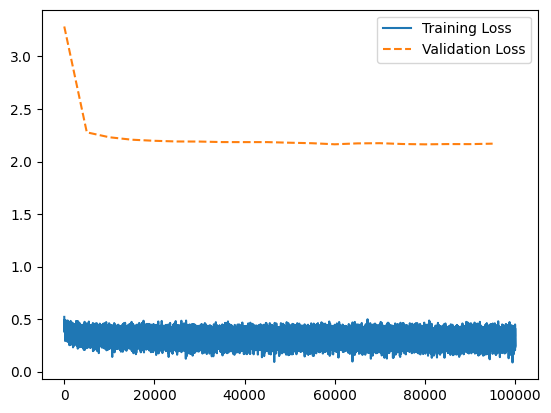

In [9]:
plt.plot(iteration_loss, label="Training Loss")
plt.plot(range(0, max_epochs, 5000), validation_loss, label="Validation Loss", linestyle='--')
plt.legend()
plt.show()

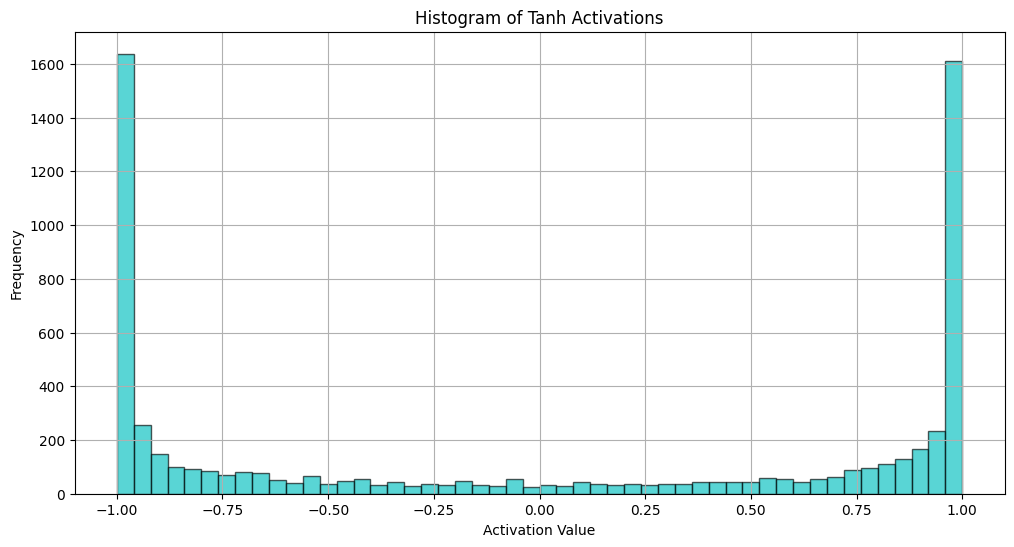

In [10]:
#Visualize Activation Gradient
hidden_activations = hidden.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.hist(hidden_activations.flatten(), bins=50, color='c', edgecolor='k', alpha=0.65)
plt.title('Histogram of Tanh Activations')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [11]:
def sample_network(context, params, block_size = 3, num_samples=1):
    C, W1, W2, b2, bnorm_gain, bnorm_bias = params
    g = torch.Generator().manual_seed(28482948204 + 10)
    samples = []
    for _ in range(num_samples):
        out = []
        context_copy = context.copy()
        while True:
            #forward pass
            embedding = C[torch.tensor([context_copy])]
            hidden = torch.tanh(embedding.view(1,-1) @ W1)
            logits = hidden @ W2 + b2
            probs = F.softmax(logits, dim=1) #convert logits into probabilities 0 to 1
            index = torch.multinomial(probs, num_samples=1,generator=g).item() #sample probabilities
            context_copy = context_copy[1:] + [index]
            out.append(index) #append output index 
            if index == 0:
                #if we reach end token, end
                break
        samples.append(''.join(I_to_S[i] for i in out)) #add the character mappings for the integers to result
    return samples
    
context = [0] * block_size
samples = sample_network(context, network_params, block_size=block_size, num_samples=20)
for sample in samples:
    print(sample) #sample 20 names from distribution

yanaryo.
lakian.
aileigh.
sheel.
damidharonia.
lucie.
natalei.
darsha.
dor.
luen.
soph.
jamelias.
nisha.
del.
zeniko.
kael.
grevandellorina.
korii.
aaren.
hryn.
